# Tabular Playground Series - Aug 2022

In this notebook, I create base model for TPS Aug 2022. In below, some information about data is gave us. 

>This data represents the results of a large product testing study. For each **product_code** you are given a number of product **attributes** (fixed for the code) as well as a number of **measurement values** for each individual product, representing various lab testing methods. Each product is used in a simulated real-world environment experiment, and and absorbs a certain amount of fluid (**loading**) to see whether or not it fails.

>Your task is to use the data to predict individual product failures of new codes with their individual lab test results.

<a id="0"></a> <br>
# Table of Contents  
1. [Introduction to Tabular Playground Series - Aug 2022](#1)     
1. [A glance at the Data](#2) 
 1. [Create Train and Test Sets](#3) 
1. [EDA](#4)
1. [Missing Values](#4)
1. [Modelling](#10)
1. [XGBoost](#20)
1. [Submission](#30)

<a id="1"></a> <br>
# 1. A glance at the Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Metrics
from sklearn.metrics import roc_auc_score

# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


In [2]:
df_train_full = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/train.csv", index_col='id')
df_test = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/test.csv", index_col='id')

df_train_full.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [3]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26570 entries, 0 to 26569
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    26570 non-null  object 
 1   loading         26320 non-null  float64
 2   attribute_0     26570 non-null  object 
 3   attribute_1     26570 non-null  object 
 4   attribute_2     26570 non-null  int64  
 5   attribute_3     26570 non-null  int64  
 6   measurement_0   26570 non-null  int64  
 7   measurement_1   26570 non-null  int64  
 8   measurement_2   26570 non-null  int64  
 9   measurement_3   26189 non-null  float64
 10  measurement_4   26032 non-null  float64
 11  measurement_5   25894 non-null  float64
 12  measurement_6   25774 non-null  float64
 13  measurement_7   25633 non-null  float64
 14  measurement_8   25522 non-null  float64
 15  measurement_9   25343 non-null  float64
 16  measurement_10  25270 non-null  float64
 17  measurement_11  25102 non-null 

In [4]:
df_train_full.describe()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,25774.000000,...,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000
mean,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,17.510759,...,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608
std,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,0.995980,...,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160
min,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,12.715000,...,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000
25%,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,16.839000,...,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000
50%,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,17.516000,...,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000
75%,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,18.178000,...,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000
max,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,21.543000,...,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000


### Ratio of the Failure on Train Set

0    20921
1     5649
Name: failure, dtype: int64


Text(0.5, 1.0, 'Failure Rate of Products on Training Set')

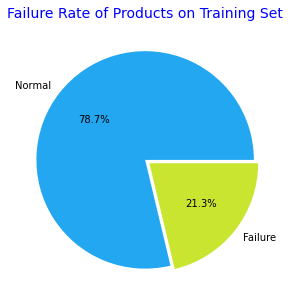

In [5]:
colors = ["#22a7f0","#c9e52f"]
labels = ['Normal', 'Failure']
explode = [0,0.05]

print(df_train_full.failure.value_counts())
           
plt.figure(figsize = (5,5))
plt.pie(df_train_full.failure.value_counts(),explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Failure Rate of Products on Training Set", color = 'blue',fontsize = 14)

### Ratio of Nan Values
There is a lot of missing value. We will deal with them later.

In [6]:
cm = sns.light_palette("red", as_cmap=True)
pd.DataFrame({"NaN Count": df_train_full.isna().sum(),
              "NaN Ratio": df_train_full.isna().sum()/len(df_train_full)}).sort_values(by="NaN Count",
                                                                 ascending=False).style.background_gradient(cmap=cm)

,NaN Count,NaN Ratio
measurement_17,2284,0.085962
measurement_16,2110,0.079413
measurement_15,2009,0.075612
measurement_14,1874,0.070531
measurement_13,1774,0.066767
measurement_12,1601,0.060256
measurement_11,1468,0.055250
measurement_10,1300,0.048927
measurement_9,1227,0.046180
measurement_8,1048,0.039443


<a id="3"></a> <br>
## 1.A. Create Train and Test Sets

In [7]:
from sklearn.model_selection import train_test_split

random_state=42

y = df_train_full["failure"]  # save target
# df_train_full.drop(['failure'], axis=1, inplace=True) # drop target
df_train = df_train_full.drop(['failure'], axis=1)

test_size = 0.2
x_train, x_val, y_train, y_val = train_test_split(df_train, y , test_size = test_size, random_state=random_state)

In [8]:
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)
print("x_val.shape: ",x_val.shape)
print("y_val.shape: ",y_val.shape)

x_train.shape:  (21256, 24)
y_train.shape:  (21256,)
x_val.shape:  (5314, 24)
y_val.shape:  (5314,)


In [9]:
df_train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885


**What's the ratio of failure numbers, after splitting data?**

In [10]:
x_train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
4031,A,125.77,material_7,material_8,9,5,13,1,3,16.957,...,21.896,NaN,14.837,17.120,13.848,16.205,14.036,12.391,15.069,879.008
2375,A,108.12,material_7,material_8,9,5,14,8,7,18.219,...,NaN,11.097,16.114,19.780,11.668,14.948,18.790,13.674,17.019,760.411
13904,C,190.34,material_7,material_8,5,8,16,11,10,17.512,...,18.780,10.582,15.999,18.201,10.160,16.337,16.701,15.145,16.283,675.360
18772,D,132.96,material_7,material_5,6,6,8,8,5,18.077,...,20.289,11.254,19.852,18.620,12.750,15.698,17.998,NaN,17.994,966.597
3884,A,108.12,material_7,material_8,9,5,11,5,4,18.878,...,18.192,10.980,14.872,21.283,11.759,16.563,17.046,14.296,14.557,566.990


Failure Rate on Splitted Training Set
 0    16664
1     4592
Name: failure, dtype: int64


Text(0.5, 1.0, 'Failure Rate on Training Set')

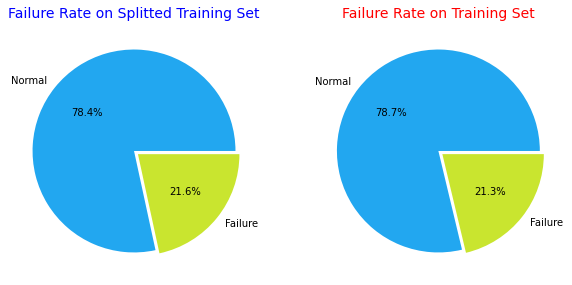

In [11]:
print("Failure Rate on Splitted Training Set\n",y_train.value_counts())
           
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.pie(y_train.value_counts(),explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Failure Rate on Splitted Training Set", color = 'blue',fontsize = 14)

plt.subplot(1,2,2)
plt.pie(df_train_full.failure.value_counts(),explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Failure Rate on Training Set", color = 'Red',fontsize = 14)

<a id="3"></a> <br>
# 2. EDA

In [12]:
for column in x_train.columns:
    if x_train[column].dtypes == "object":
        print("\n",column)
        print(x_train[column].value_counts())

attributes = ["attribute_2", "attribute_3"]
print("\n",attributes[0])
print(x_train[attributes[0]].value_counts())
print("\n",attributes[1])
print(x_train[attributes[1]].value_counts())

# categorical_columns = 

# cm = sns.light_palette("red", as_cmap=True)
# pd.DataFrame({"NaN Count": df.isna().sum(),
#               "NaN Ratio": df.isna().sum()/len(df)}).sort_values(by="NaN Count",
#                                                                  ascending=False).style.background_gradient(cmap=cm)


 product_code
C    4615
E    4251
B    4175
D    4144
A    4071
Name: product_code, dtype: int64

 attribute_0
material_7    17081
material_5     4175
Name: attribute_0, dtype: int64

 attribute_1
material_8    8686
material_5    8319
material_6    4251
Name: attribute_1, dtype: int64

 attribute_2
6    8395
5    4615
8    4175
9    4071
Name: attribute_2, dtype: int64

 attribute_3
8    8790
9    4251
6    4144
5    4071
Name: attribute_3, dtype: int64


<a id="4"></a> <br>
## 2. Missing Values

In [13]:
x_train.isnull().sum()

product_code         0
loading            207
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      293
measurement_4      439
measurement_5      539
measurement_6      627
measurement_7      738
measurement_8      852
measurement_9      972
measurement_10    1042
measurement_11    1153
measurement_12    1315
measurement_13    1401
measurement_14    1496
measurement_15    1623
measurement_16    1699
measurement_17    1837
dtype: int64

<div class="alert alert-block alert-warning">
<b>Remember:</b> Null Values can be a sign of failure.
</div>

In [14]:
numerical_cols = [c for c in x_train.columns if x_train[c].dtypes in ['int', 'float']]
print("Numerical Columns", numerical_cols)

categorical_cols = [c for c in x_train.columns if x_train[c].dtypes in ['object']]
print("\nCategorical Columns", categorical_cols)

Numerical Columns ['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']

Categorical Columns ['product_code', 'attribute_0', 'attribute_1']


## Transformers

In [15]:
# Preprocessing for numerical data
# it was constant
# numerical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),
#                                         ('std_scaler', StandardScaler())
#                                        ]) 

numerical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='median'))
                                       ]) 

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [16]:
x_train.head(10)

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
4031,A,125.77,material_7,material_8,9,5,13,1,3,16.957,...,21.896,NaN,14.837,17.120,13.848,16.205,14.036,12.391,15.069,879.008
2375,A,108.12,material_7,material_8,9,5,14,8,7,18.219,...,NaN,11.097,16.114,19.780,11.668,14.948,18.790,13.674,17.019,760.411
13904,C,190.34,material_7,material_8,5,8,16,11,10,17.512,...,18.780,10.582,15.999,18.201,10.160,16.337,16.701,15.145,16.283,675.360
18772,D,132.96,material_7,material_5,6,6,8,8,5,18.077,...,20.289,11.254,19.852,18.620,12.750,15.698,17.998,NaN,17.994,966.597
3884,A,108.12,material_7,material_8,9,5,11,5,4,18.878,...,18.192,10.980,14.872,21.283,11.759,16.563,17.046,14.296,14.557,566.990
18347,D,144.12,material_7,material_5,6,6,7,8,6,16.929,...,18.541,9.553,13.386,20.145,11.973,16.659,15.823,13.875,18.638,804.271
5610,B,171.30,material_5,material_5,8,8,6,9,6,15.724,...,18.470,10.543,15.388,18.421,10.796,14.399,16.273,12.998,17.569,660.654
21940,E,174.71,material_7,material_6,6,9,3,18,0,18.154,...,18.990,13.491,17.749,19.830,10.391,NaN,14.896,13.928,15.057,762.758
25511,E,189.11,material_7,material_6,6,9,5,8,8,17.781,...,18.195,12.326,16.642,21.269,12.471,15.330,15.751,15.165,18.934,706.423


### Apply Preprocess and put on Pd DataFrame

In [17]:
# x_train[numerical_cols] = numerical_transformer.fit_transform(x_train[numerical_cols])

# x_train.head(10)

In [18]:
# x_train[categorical_cols] = categorical_transformer.fit_transform(x_train[categorical_cols])
# x_train.head()

### Apply Preprocess

In [19]:
x_train = preprocessor.fit_transform(x_train)
x_val = preprocessor.transform(x_val)

In [20]:
x_train

array([[125.77,   9.  ,   5.  , ...,   0.  ,   0.  ,   1.  ],
       [108.12,   9.  ,   5.  , ...,   0.  ,   0.  ,   1.  ],
       [190.34,   5.  ,   8.  , ...,   0.  ,   0.  ,   1.  ],
       ...,
       [115.63,   9.  ,   5.  , ...,   0.  ,   0.  ,   1.  ],
       [216.26,   5.  ,   8.  , ...,   0.  ,   0.  ,   1.  ],
       [120.65,   6.  ,   9.  , ...,   0.  ,   1.  ,   0.  ]])

<a id="10"></a> <br>
# Modelling

<a id="11"></a> <br>
## RandomForestClassifier

In [21]:
%%time
model = RandomForestClassifier(n_estimators=100, random_state=0)

model.fit(x_train, y_train)

CPU times: user 10 s, sys: 40.7 ms, total: 10.1 s
Wall time: 10.1 s


RandomForestClassifier(random_state=0)

In [22]:
# We validate the model
y_val_pred = model.predict_proba(x_val)[:,1]
score = roc_auc_score(y_val, y_val_pred)
print(f"auc = {score:.5f}")

auc = 0.54396


<a id="12"></a> <br>
## LogisticRegression

In [23]:
%%time

model = LogisticRegression()
model.fit(x_train, y_train)

# We validate the model
y_val_pred = model.predict_proba(x_val)[:,1]
score = roc_auc_score(y_val, y_val_pred)
print(f"auc = {score:.5f}")

auc = 0.59370
CPU times: user 731 ms, sys: 424 ms, total: 1.16 s
Wall time: 295 ms


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


<a id="20"></a> <br>
# XGBoost

In [24]:
# !pip install --upgrade xgboost

In [25]:
from xgboost import XGBClassifier

In [26]:
%%time
xgb_clf = XGBClassifier()

xgb_clf.fit(x_train, y_train)

CPU times: user 13.7 s, sys: 52.2 ms, total: 13.8 s
Wall time: 3.47 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [27]:
# We validate the model
y_val_pred = xgb_clf.predict_proba(x_val)[:,1]
score = roc_auc_score(y_val, y_val_pred)
print(f"auc = {score:.5f}")

auc = 0.54529


<a id="30"></a> <br>
# Submission

In [28]:
x_test = preprocessor.transform(df_test)

In [29]:
test_pred = model.predict_proba(x_test)[:,1]
test_pred

array([0.22856407, 0.17381209, 0.20624759, ..., 0.14175294, 0.21970829,
       0.17700166])

In [30]:
submission = pd.DataFrame({'id': df_test.index,
                           'failure': test_pred})
submission.to_csv('submission.csv', index=False)
submission

,id,failure
0,26570,0.228564
1,26571,0.173812
2,26572,0.206248
3,26573,0.214283
4,26574,0.367757
...,...,...
20770,47340,0.227052
20771,47341,0.172962
20772,47342,0.141753
20773,47343,0.219708
